In [1]:
# -- coding: utf-8 --
# This code is part of Qiskit.
#
# (C) Copyright IBM 2019.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

In [1]:
import torch
from torch.autograd import Function
import torch.optim as optim

In [2]:
from qiskit import QuantumRegister,QuantumCircuit,ClassicalRegister,execute
from qiskit.circuit import Parameter
from qiskit import Aer
import numpy as np

/mnt/c/Users/dumon/Documents/Personal/quantum/ibm-qiskitcamp/qiskit-terra/qiskit/pulse/channels/pulse_channels.py:25: DeprecationWarning: Channels have been migrated. Please use `from qiskit.pulse.channels import X` rather than `from qiskit.pulse.channels.pulse_channels import X`.
  DeprecationWarning)


In [3]:
from tqdm import tqdm

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
np.random.seed = 42

In [115]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

class QiskitCircuit():
    
    def __init__(self,shots):
        self.theta = Parameter('Theta')
        self.phi = Parameter('Phi')
        self.lam = Parameter('Lambda')
        self.shots = shots
        
        def create_circuit():
            qr = QuantumRegister(1,'q')
            cr = ClassicalRegister(1,'c')
            ckt = QuantumCircuit(qr,cr)
            ckt.h(qr[0])
            ckt.barrier()
            ckt.u3(self.theta,self.phi,self.lam,qr[0])
            ckt.barrier()
            ckt.measure(qr,cr)
            return ckt
        
        self.circuit = create_circuit()
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(nr_qubits)
        for key in counts.keys():
            perc = counts[key]/shots
            check = np.array([(float(key[i])-1/2)*2*perc for i in range(nr_qubits)])
            expects += check   
        return expects    
    
    def bind(self, parameters):
        [self.theta,self.phi,self.lam] = to_numbers(parameters)
        self.circuit.data[2][0]._params = to_numbers(parameters)
    
    def run(self, i):
        self.bind(i)
        
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,backend,shots=self.shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts,self.shots,1)

class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(shots=10000)
            
        exp_value = ctx.QiskitCirc.run(i[0])
        
        result = torch.tensor([exp_value])
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        eps = 0.01
        
        forward_tensor, i = ctx.saved_tensors    
        input_numbers = to_numbers(i[0])
        gradient = [0,0,0]
        
        for k in range(len(input_numbers)):
            input_eps = input_numbers
            input_eps[k] = input_numbers[k] + eps

            exp_value = ctx.QiskitCirc.run(torch.tensor(input_eps))[0]
            result_eps = torch.tensor([exp_value])
            gradient_result = (exp_value - forward_tensor[0][0].item())/eps
            gradient[k] = gradient_result
            
#         print(gradient)
        result = torch.tensor([gradient])
#         print(result)

        return result.float() * grad_output.float()

In [116]:
torch.manual_seed(42)

In [123]:
# x = torch.tensor([np.pi/4, np.pi/4, np.pi/4], requires_grad=True)
x = torch.tensor([[0.0, 0.0, 0.0]], requires_grad=True)

qc = TorchCircuit.apply
y1 = qc(x)
y1.backward()
print(x.grad)

tensor([[ 0.7400, -0.6600,  0.8800]])


100%|██████████| 100/100 [00:21<00:00,  4.74it/s]


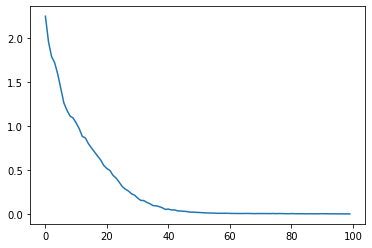

In [134]:
qc = TorchCircuit.apply

def cost(x):
    target = -1
    expval = qc(x)
    return torch.abs(qc(x) - target) ** 2, expval

x = torch.tensor([[np.pi/4, np.pi/4, np.pi/4]], requires_grad=True)
opt = torch.optim.Adam([x], lr=0.1)

num_epoch = 100

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
# for i in range(num_epoch):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval.item())
#     print(loss.item())

plt.plot(loss_list)
    
# print(circuit(phi, theta))
# print(cost(x))

### MNIST in pytorch

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [53]:
import numpy as np
import torchvision
from torchvision import datasets, transforms

batch_size_train = 1
batch_size_test = 1
learning_rate = 0.01
momentum = 0.5
log_interval = 10

torch.backends.cudnn.enabled = False

transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

labels = mnist_trainset.targets #get labels
labels = labels.numpy()
idx1 = np.where(labels == 0) #search all zeros
idx2 = np.where(labels == 1) # search all ones
idx = np.concatenate((idx1[0][0:10],idx2[0][0:10])) # concatenate their indices
mnist_trainset.targets = labels[idx] 
mnist_trainset.data = mnist_trainset.data[idx]

print(mnist_trainset)

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size_train, shuffle=True)

Dataset MNIST
    Number of datapoints: 20
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [141]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
#         x = np.pi*F.tanh(x)
        print(x)
        x = qc(x)
#         print(x)
        x = (x+1)/2
        x = torch.cat((x, 1-x), -1)
        return x
#         return F.softmax(x)

In [142]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [ ]:
epochs = 100
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
#         print(batch_idx)
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
#         print(output)
#         print(output[0][1].item(), target.item())
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    print(sum(total_loss)/len(total_loss))

tensor([[ 0.2786,  0.2090, -0.2184]], grad_fn=<AddmmBackward>)
tensor([[ 0.1152, -0.0886, -0.0136]], grad_fn=<AddmmBackward>)
tensor([[ 0.1689, -0.0758, -0.0134]], grad_fn=<AddmmBackward>)
tensor([[ 0.0985,  0.0167, -0.1019]], grad_fn=<AddmmBackward>)
tensor([[ 0.2348,  0.0253, -0.0513]], grad_fn=<AddmmBackward>)
tensor([[-0.0583, -0.2359, -0.1303]], grad_fn=<AddmmBackward>)
tensor([[ 0.1418, -0.0449, -0.1071]], grad_fn=<AddmmBackward>)
tensor([[ 0.2100, -0.2352, -0.2333]], grad_fn=<AddmmBackward>)
tensor([[ 0.4797, -0.3208,  0.0254]], grad_fn=<AddmmBackward>)
tensor([[ 0.1151, -0.2707, -0.2813]], grad_fn=<AddmmBackward>)
tensor([[ 0.3336, -0.1242, -0.1182]], grad_fn=<AddmmBackward>)
tensor([[ 0.2711, -0.0834, -0.1516]], grad_fn=<AddmmBackward>)
tensor([[ 0.2301, -0.0510, -0.1991]], grad_fn=<AddmmBackward>)
tensor([[ 0.2075, -0.1556, -0.0832]], grad_fn=<AddmmBackward>)
tensor([[ 0.2658, -0.1213, -0.1209]], grad_fn=<AddmmBackward>)
tensor([[ 0.2425, -0.1130,  0.0032]], grad_fn=<AddmmBac

tensor([[ 0.1853, -0.1606, -0.2336]], grad_fn=<AddmmBackward>)
tensor([[ 0.3254, -0.1267, -0.1557]], grad_fn=<AddmmBackward>)
tensor([[ 0.2241, -0.1063, -0.1945]], grad_fn=<AddmmBackward>)
tensor([[ 0.3797, -0.0851, -0.1125]], grad_fn=<AddmmBackward>)
tensor([[ 0.3952, -0.0357, -0.0539]], grad_fn=<AddmmBackward>)
tensor([[ 0.3204, -0.0846, -0.0917]], grad_fn=<AddmmBackward>)
tensor([[ 0.3245, -0.0507, -0.1034]], grad_fn=<AddmmBackward>)
tensor([[ 0.3193, -0.0350, -0.0934]], grad_fn=<AddmmBackward>)
tensor([[ 0.3226, -0.0326, -0.1039]], grad_fn=<AddmmBackward>)
tensor([[0.4941, 0.0089, 0.0022]], grad_fn=<AddmmBackward>)
-0.49257000000000006
tensor([[ 6.2356e-01,  4.3496e-04, -2.7264e-02]], grad_fn=<AddmmBackward>)
tensor([[ 0.2022, -0.0690, -0.1557]], grad_fn=<AddmmBackward>)
tensor([[ 0.5133, -0.0242, -0.0024]], grad_fn=<AddmmBackward>)
tensor([[ 0.3906, -0.0684, -0.1543]], grad_fn=<AddmmBackward>)
tensor([[ 0.2569, -0.0976, -0.1142]], grad_fn=<AddmmBackward>)
tensor([[ 0.2286, -0.1025

tensor([[ 5.7035e-01, -9.7577e-02,  5.0621e-04]], grad_fn=<AddmmBackward>)
-0.4999300000000001
tensor([[ 0.5474, -0.1046, -0.0537]], grad_fn=<AddmmBackward>)
tensor([[ 0.4464, -0.1181, -0.1495]], grad_fn=<AddmmBackward>)
tensor([[0.6484, 0.0425, 0.0109]], grad_fn=<AddmmBackward>)
tensor([[ 0.5127, -0.0233, -0.0943]], grad_fn=<AddmmBackward>)
tensor([[ 0.8664, -0.1261,  0.1187]], grad_fn=<AddmmBackward>)
tensor([[0.7936, 0.0077, 0.0712]], grad_fn=<AddmmBackward>)
tensor([[ 0.8088, -0.0802, -0.0250]], grad_fn=<AddmmBackward>)
tensor([[ 0.4727, -0.0726, -0.0443]], grad_fn=<AddmmBackward>)
tensor([[ 1.1247, -0.0867,  0.2139]], grad_fn=<AddmmBackward>)
tensor([[ 0.4749, -0.1493, -0.1014]], grad_fn=<AddmmBackward>)
tensor([[ 0.7039, -0.1187, -0.0433]], grad_fn=<AddmmBackward>)
tensor([[ 0.8507, -0.1378, -0.0358]], grad_fn=<AddmmBackward>)
tensor([[ 0.4727, -0.0539,  0.0407]], grad_fn=<AddmmBackward>)
tensor([[ 0.6914, -0.1505,  0.0479]], grad_fn=<AddmmBackward>)
tensor([[ 0.6034, -0.0719, -0

tensor([[ 0.6696, -0.2017,  0.3891]], grad_fn=<AddmmBackward>)
tensor([[ 0.4973, -0.3403,  0.4410]], grad_fn=<AddmmBackward>)
tensor([[ 0.4289, -0.1434,  0.2154]], grad_fn=<AddmmBackward>)
tensor([[ 0.7312, -0.1984,  0.0905]], grad_fn=<AddmmBackward>)
tensor([[ 0.7821, -0.1496,  0.2779]], grad_fn=<AddmmBackward>)
tensor([[ 0.5200, -0.1804,  0.1353]], grad_fn=<AddmmBackward>)
tensor([[ 1.1022, -0.1788,  0.3136]], grad_fn=<AddmmBackward>)
tensor([[ 0.4665, -0.2069,  0.2985]], grad_fn=<AddmmBackward>)
tensor([[ 0.7802, -0.1931,  0.4592]], grad_fn=<AddmmBackward>)
tensor([[ 0.5635, -0.1530,  0.2467]], grad_fn=<AddmmBackward>)
tensor([[ 0.9599, -0.2368,  0.7166]], grad_fn=<AddmmBackward>)
tensor([[ 0.5253, -0.1020,  0.2436]], grad_fn=<AddmmBackward>)
tensor([[ 0.5207, -0.0939,  0.1581]], grad_fn=<AddmmBackward>)
-0.47700999999999993
tensor([[ 0.6942, -0.1124,  0.3969]], grad_fn=<AddmmBackward>)
tensor([[ 0.7536, -0.2454,  0.4832]], grad_fn=<AddmmBackward>)
tensor([[ 0.8266, -0.1396,  0.4176

tensor([[ 0.7724, -0.0633,  0.6291]], grad_fn=<AddmmBackward>)
tensor([[ 0.7123, -0.3271,  0.5451]], grad_fn=<AddmmBackward>)
tensor([[ 0.6757, -0.3627,  0.6654]], grad_fn=<AddmmBackward>)
-0.49072999999999983
tensor([[ 0.6228, -0.0679,  0.3951]], grad_fn=<AddmmBackward>)
tensor([[ 1.2556, -0.3419,  1.0914]], grad_fn=<AddmmBackward>)
tensor([[ 0.5629, -0.0944,  0.4301]], grad_fn=<AddmmBackward>)
tensor([[ 0.5665, -0.1320,  0.4562]], grad_fn=<AddmmBackward>)
tensor([[ 0.7351, -0.1200,  0.5407]], grad_fn=<AddmmBackward>)
tensor([[ 0.8428, -0.3912,  0.5667]], grad_fn=<AddmmBackward>)
tensor([[ 1.1864, -0.3622,  0.8198]], grad_fn=<AddmmBackward>)
tensor([[ 1.4926, -0.1572,  1.0175]], grad_fn=<AddmmBackward>)
tensor([[ 0.5748, -0.0776,  0.4896]], grad_fn=<AddmmBackward>)
tensor([[ 1.1354, -0.0638,  0.8086]], grad_fn=<AddmmBackward>)
tensor([[ 1.1780, -0.1440,  0.9493]], grad_fn=<AddmmBackward>)
tensor([[ 1.3976, -0.0399,  0.9789]], grad_fn=<AddmmBackward>)
tensor([[ 1.3424, -0.2415,  1.2041